# Strava Moving Time estimator by Scikit-Learn

In [1]:
import numpy
import pandas
import matplotlib.pyplot as plt
import scipy.stats
from sklearn.linear_model import LinearRegression # Regression Model
from sklearn.model_selection import train_test_split # to split train and test sets
plt.style.use("bmh")
%config InlineBackend.figure_formats=["png"]

Let's assume to have already downloaded the activities.csv file from our Strava profile.

In [8]:
activities = pandas.read_csv("activities.csv")
print("dataset type is:", type(activities), "length:", len(activities), "shape:", activities.shape)

dataset type is: <class 'pandas.core.frame.DataFrame'> length: 855 shape: (855, 86)


The dataset is really rich. It includes 86 columns for each route. 
Not all the columns contain usable data because I don't have a Strava subscription, but only a free account.

In [9]:
print("columns: ", len(list(activities.columns)))

columns:  86


In [10]:
activities.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 855 entries, 0 to 854
Data columns (total 86 columns):
 #   Column                                                                                                                                                                                          Non-Null Count  Dtype  
---  ------                                                                                                                                                                                          --------------  -----  
 0   Activity ID                                                                                                                                                                                     855 non-null    int64  
 1   Activity Date                                                                                                                                                                                   855 non-null    object 
 2   Activi

In [11]:
list(activities.columns)

['Activity ID',
 'Activity Date',
 'Activity Name',
 'Activity Type',
 'Activity Description',
 'Elapsed Time',
 'Distance',
 'Max Heart Rate',
 'Relative Effort',
 'Commute',
 'Activity Private Note',
 'Activity Gear',
 'Filename',
 'Athlete Weight',
 'Bike Weight',
 'Elapsed Time.1',
 'Moving Time',
 'Distance.1',
 'Max Speed',
 'Average Speed',
 'Elevation Gain',
 'Elevation Loss',
 'Elevation Low',
 'Elevation High',
 'Max Grade',
 'Average Grade',
 'Average Positive Grade',
 'Average Negative Grade',
 'Max Cadence',
 'Average Cadence',
 'Max Heart Rate.1',
 'Average Heart Rate',
 'Max Watts',
 'Average Watts',
 'Calories',
 'Max Temperature',
 'Average Temperature',
 'Relative Effort.1',
 'Total Work',
 'Number of Runs',
 'Uphill Time',
 'Downhill Time',
 'Other Time',
 'Perceived Exertion',
 '<span class="translation_missing" title="translation missing: en-US.lib.export.portability_exporter.activities.horton_values.type">Type</span>',
 '<span class="translation_missing" title="tr

Of course not all the columns are helpful. So let's extract only the columns really helpful to train a model.

After a fast analysis of the available features, only the following features will be used to train the model:
- Distance
- Elevation gain
- Max Grade
- Average Grade

The target label is the 'Moving Time'.

Our task is to train a model to predict the expected 'Moving time' given the Distance, the Elevation Gain, the Max Grade, the Average Grade.

These informations can be retrieved by Rouvy, the well know virtual biking app.

<img src="rouvy.png" alt="Rouvy data for a route" />

or from Google Maps

<img src="google-maps.png" alt="Google Maps data for a route" />

## Dropping 'walk' activities

In [13]:
activities = activities.drop(activities[activities['Activity Type'] == 'Walk'].index)

In [14]:
activities.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 713 entries, 0 to 854
Data columns (total 86 columns):
 #   Column                                                                                                                                                                                          Non-Null Count  Dtype  
---  ------                                                                                                                                                                                          --------------  -----  
 0   Activity ID                                                                                                                                                                                     713 non-null    int64  
 1   Activity Date                                                                                                                                                                                   713 non-null    object 
 2   Activi

## Dropping short routes

Sometimes short routes have been recorded as for example the 'Warm up' and 'Cool down' routes under Rouvy. They are not useful for our purposes. So let's remove all the routes whose 'Moving Time' is less than 3 minutes (180 secs).

In [15]:
activities = activities.drop(activities[activities['Moving Time'] < 180].index)

In [17]:
activities.describe()

,Activity ID,Elapsed Time,Distance,Max Heart Rate,Relative Effort,Athlete Weight,Bike Weight,Elapsed Time.1,Moving Time,Distance.1,...,"<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.jump_count"">Jump Count</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.total_grit"">Total Grit</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.avg_flow"">Avg Flow</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.flagged"">Flagged</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.avg_elapsed_speed"">Avg Elapsed Speed</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.dirt_distance"">Dirt Distance</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.newly_explored_distance"">Newly Explored Distance</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.newly_explored_dirt_distance"">Newly Explored Dirt Distance</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.sport_type"">Sport Type</span>","<span class=""translation_missing"" title=""translation missing: en-US.lib.export.portability_exporter.activities.horton_values.total_steps"">Total Steps</span>"
count,6.260000e+02,626.000000,626.000000,309.000000,309.000000,91.0,497.0,619.000000,626.000000,626.000000,...,0.0,0.0,0.0,293.0,324.000000,273.000000,0.0,0.0,0.0,0.0
mean,5.585464e+09,5328.990415,30.415799,162.721683,91.090615,0.0,8.0,5262.512116,4774.672524,30419.188713,...,NaN,NaN,NaN,0.0,6.974121,724.742495,NaN,NaN,NaN,NaN
std,1.866437e+09,4892.904216,23.546315,15.412095,70.448504,0.0,0.0,4832.269054,3755.862461,23546.231222,...,NaN,NaN,NaN,0.0,2.760826,2582.367621,NaN,NaN,NaN,NaN
min,1.658492e+09,183.000000,0.000000,94.000000,0.000000,0.0,8.0,183.000000,183.000000,0.000000,...,NaN,NaN,NaN,0.0,0.000000,0.000000,NaN,NaN,NaN,NaN
25%,4.214110e+09,2155.250000,11.762500,158.000000,36.000000,0.0,8.0,2148.000000,2134.000000,11763.867676,...,NaN,NaN,NaN,0.0,5.021870,0.000000,NaN,NaN,NaN,NaN
50%,5.692461e+09,3999.500000,25.335000,163.000000,74.000000,0.0,8.0,3979.000000,3849.000000,25339.915039,...,NaN,NaN,NaN,0.0,7.473115,0.000000,NaN,NaN,NaN,NaN
75%,7.273444e+09,6934.750000,40.432500,167.000000,136.000000,0.0,8.0,6842.500000,6138.250000,40439.250977,...,NaN,NaN,NaN,0.0,8.806412,17.299999,NaN,NaN,NaN,NaN
max,8.413395e+09,54601.000000,118.010000,240.000000,342.000000,0.0,8.0,54601.000000,21230.000000,118013.898438,...,NaN,NaN,NaN,0.0,18.036757,19936.099609,NaN,NaN,NaN,NaN


Let's extract only the required columns from the original activities dataset.

In [18]:
activities = activities[["Distance", "Elevation Gain", "Max Grade", "Average Grade", "Moving Time", "Max Speed"]]

In [24]:
mph2kmh=0.621371192
activities['Max Speed'] = activities['Max Speed']/mph2kmh

In [25]:
activities.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 626 entries, 0 to 854
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Distance        626 non-null    float64
 1   Elevation Gain  623 non-null    float64
 2   Max Grade       625 non-null    float64
 3   Average Grade   626 non-null    float64
 4   Moving Time     626 non-null    float64
 5   Max Speed       625 non-null    float64
dtypes: float64(6)
memory usage: 34.2 KB


Let's take a look at the data content

In [26]:
activities.head()

,Distance,Elevation Gain,Max Grade,Average Grade,Moving Time,Max Speed
0,59.08,412.800842,9.400000,0.000169,10637.0,19.633997
1,16.11,305.050537,41.099998,0.088097,2807.0,19.312128
2,35.56,114.721718,11.100000,-0.001125,5067.0,17.702784
3,38.19,347.717133,27.500000,0.026182,5407.0,18.507456
4,38.43,626.462158,49.700001,0.216715,6473.0,19.955865


In [27]:
activities.describe()

,Distance,Elevation Gain,Max Grade,Average Grade,Moving Time,Max Speed
count,626.000000,623.000000,625.000000,626.000000,626.000000,625.000000
mean,30.415799,417.646242,12.807065,0.913913,4774.672524,23.255836
std,23.546315,375.126840,9.461168,2.316492,3755.862461,7.688362
min,0.000000,0.000000,0.000000,-7.224899,183.000000,0.000000
25%,11.762500,114.860859,6.906785,-0.006147,2134.000000,19.373283
50%,25.335000,313.000000,11.200000,0.002381,3849.000000,22.691751
75%,40.432500,618.542542,15.500000,0.723731,6138.250000,28.350230
max,118.010000,2275.000000,50.000000,11.200340,21230.000000,125.689764


We can check the 'null' values and remove them if present.

In [30]:
if activities.isnull().values.any():
    print("removing null values ...")
    activities=activities.dropna()

removing null values ...


In [31]:
activities.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 622 entries, 0 to 854
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Distance        622 non-null    float64
 1   Elevation Gain  622 non-null    float64
 2   Max Grade       622 non-null    float64
 3   Average Grade   622 non-null    float64
 4   Moving Time     622 non-null    float64
 5   Max Speed       622 non-null    float64
dtypes: float64(6)
memory usage: 34.0 KB


Now we have removed the four rows with 'null' or 'NaN' from the dataframe. 

## Visualization

We can obtain a first impression of the dependency between variables by examining a multidimensional scatterplot.

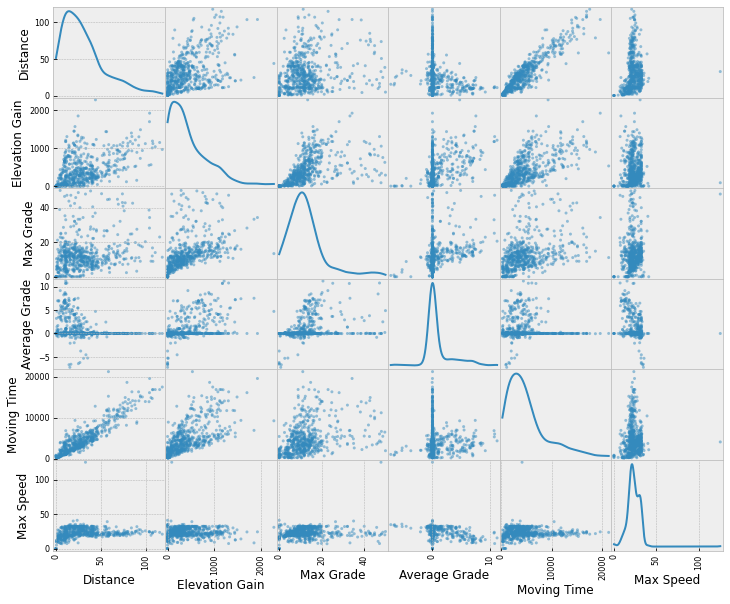

In [32]:
from pandas.plotting import scatter_matrix
scatter_matrix(activities, diagonal="kde", figsize=(12,10));

As expected we can see a linear relationship between the Moving Time and the Distance.

<AxesSubplot:xlabel='Distance', ylabel='Moving Time'>

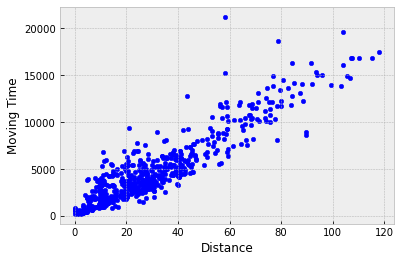

In [34]:
activities.plot(kind="scatter", x='Distance', y='Moving Time', grid=True)

there is an approximately linear relationship between Elevation Gain and the Distance: more Kms more the overall gain in altitude

<AxesSubplot:xlabel='Distance', ylabel='Elevation Gain'>

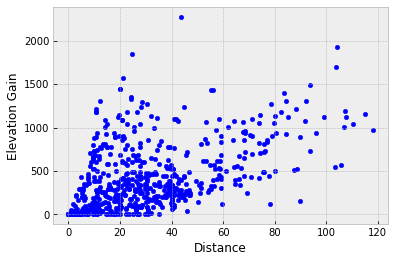

In [35]:
activities.plot(kind="scatter", x='Distance', y='Elevation Gain', grid=True)

We can also generate a 3D plot of the observations, which can sometimes help to interpret the data more easily. Here we plot 'Moving Time' as a function of 'Distance' and 'Elevation Gain'.

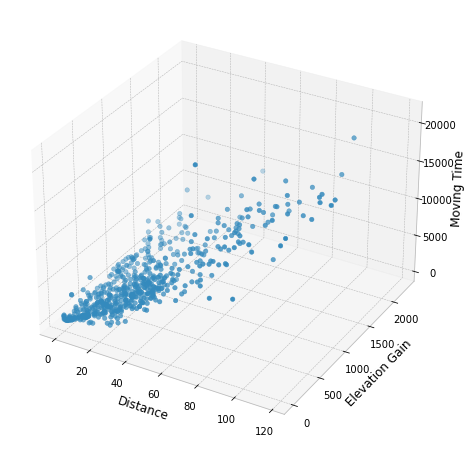

In [36]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(projection="3d")
ax.scatter(activities["Distance"], activities["Elevation Gain"], activities["Moving Time"])
ax.set_xlabel("Distance")
ax.set_ylabel("Elevation Gain")
ax.set_zlabel("Moving Time")
ax.set_facecolor("white")

## Looking for correlation

You can easily compute the standard correlation coefficient (also called Pearson's r) between every pair of attributes using the 'corr()' method.

In [37]:
corr_matrix= activities.corr()

In [38]:
corr_matrix["Distance"].sort_values(ascending=False)

Distance          1.000000
Moving Time       0.913971
Elevation Gain    0.482455
Max Grade         0.221578
Max Speed         0.153486
Average Grade    -0.298128
Name: Distance, dtype: float64

As expected the 'Distance' is strongly correlated to the 'Moving Time' (0.87) and a bit less (0.59) to the 'Elevation Gain'.

## Getting the 'labels' and 'features'

In [39]:
labels=activities.pop("Moving Time")

In [40]:
print("label shape:", labels.shape, "and type:", type(labels))

label shape: (622,) and type: <class 'pandas.core.series.Series'>


In [42]:
print("features shape:", activities.shape, "and type:", type(activities))

features shape: (622, 5) and type: <class 'pandas.core.frame.DataFrame'>


## Split training and test set

In [43]:
X = activities.values  # values converts it into a numpy array
Y = labels.values

In [44]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y)

In [45]:
X_train.shape

(466, 5)

In [46]:
X_test.shape

(156, 5)

## Model Training

We will created a fitted linear model using the formula API of the scikit-learn library.

In [47]:
linear_model = LinearRegression()
linear_model.fit(X_train, Y_train) 

LinearRegression()

### View Parameters 
The $\mathbf{w}$ and $\mathbf{b}$ parameters are referred to as 'coefficients' and 'intercept' in scikit-learn. In other term the model function can be written as $f_{w,b}(\vec{x})$

In [48]:
b = linear_model.intercept_
w = linear_model.coef_
print(f"w = {w:}, b = {b:0.2f}")

w = [129.48253617   2.19039106  42.18915582   7.78943018 -53.96239326], b = 640.16


Let's give it a try

In [49]:
some_data=X_test[5:10,:]
some_labels=Y_test[5:10]

In [50]:
some_labels_predicted = linear_model.predict(some_data)

In [51]:
print("Predictions (secs):", some_labels_predicted)

Predictions (secs): [ 4211.56843399  2895.22821822  4484.72053834 15524.1566092
  2521.36269312]


In [52]:
print("Labels (secs):", some_labels)

Labels (secs): [ 4017.  3433.  5496. 13898.  2331.]


Let’s measure this regression model’s RMSE on the whole training set using Scikit-Learn’s mean_squared_error function

In [53]:
from sklearn.metrics import mean_squared_error

In [54]:
lin_mse = mean_squared_error(some_labels, some_labels_predicted)
lin_rmse = numpy.sqrt(lin_mse)
lin_rmse

897.8156589118108

It's a little bit high. Something doesn't work as expected. The Linear model assumption seems to be not right.

## Calculate accuracy

You can calculate this accuracy of this model by calling the `score` function.

In [55]:
print("Accuracy on training set:", linear_model.score(X_train, Y_train))

Accuracy on training set: 0.9111046681311523


The accuracy on the training set is good enough but not high. The model is underfitting.

In [56]:
print("Accuracy on test set:", linear_model.score(X_test, Y_test))

Accuracy on test set: 0.9230809528021929
